# Preprocessing step

In [13]:
%pip install soundata numpy librosa matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.7-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 11.5 MB/s eta 0:00:00a 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 11.4 MB/s eta 0:00:00a 0:00:01
Using cached kiwisolver-1.4.7-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 11.5 MB/s eta 0:00:00a 0:00:01
Using cached pyparsing-3.2.0-py3-none-any.whl (106 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import soundata
import numpy as np

## Required for compatibility with the soundata library
np.float_ = np.float64

dataset = soundata.initialize('urbansound8k')
dataset.download()
dataset.validate()

example_clip = dataset.choice_clip() 
print(example_clip)

INFO: Downloading ['all', 'index']. Index is being stored in /home/guus/vscodeProjects/api-multi-label-classification/.venv/lib/python3.10/site-packages/soundata/datasets/indexes, and the rest of files in /home/guus/sound_datasets/urbansound8k
INFO: [all] downloading UrbanSound8K.tar.gz
5.61GB [08:32, 11.7MB/s]                               
INFO: [index] downloading urbansound8k_index_1.0.json
1.15MB [00:00, 2.76MB/s]                            
100%|██████████| 8732/8732 [00:08<00:00, 1091.05it/s]
INFO: Success: the dataset is complete and all files are valid.
INFO: --------------------


Clip(
  audio_path="/home/guus/sound_datasets/urbansound8k/audio/fold5/113601-9-0-3.wav",
  clip_id="113601-9-0-3",
  audio: The clip's audio
            * np.ndarray - audio signal
            * float - sample rate,
  class_id: The clip's class id.
            * int - integer representation of the class label (0-9). See Dataset Info in the documentation for mapping,
  class_label: The clip's class label.
            * str - string class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music,
  fold: The clip's fold.
            * int - fold number (1-10) to which this clip is allocated. Use these folds for cross validation,
  freesound_end_time: The clip's end time in Freesound.
            * float - end time in seconds of the clip in the original freesound recording,
  freesound_id: The clip's Freesound ID.
            * str - ID of the freesound.org recording from which this clip was taken,
  freesound_start_ti

## melspectogram instructions
Goal: mel spectogram with resolution of 48 frequencies from 40hz upto 16khz.
with 32 time steps of 1/16th of a second with a half overlap during 1 second.
We assume the data is streaming.
data from the last 1/32th of the last second of the previous sample is added to the next.
so in total 48 frequency bands and 32 spectra
- audio sample between 1 and 16 seconds
- apply hann window function
- apply fourier transform to get absolute spectrum
- summize spectral components using MEL filters.
MEL spectral filters should be done using melbankm.m from VOICEBOX speech processing toolbox. http://www.ee.ic.ac.uk/hp/staff/dmb/voicebox/voicebox.html
as follows: [m,mc,mn]=melbankm(p,n,fs,fl,fh,w) where p=48,n=3000,fs=48000,fl=40,fh=16000,w="ch"
output m is matrix of filter values, mc and mn are frequency border and indices
- After this output the matrix is edited as follows
  - log on all components using natural log and a low pass filter of epsil = 1e-6, so x = log(Svalue, epsil)
  - normalize the mel spectro gram for training and classification, so all melspectograms have max value of 2:
Xnorm(:,:) = X(:,:)- max(max(X(:,:))) +2;

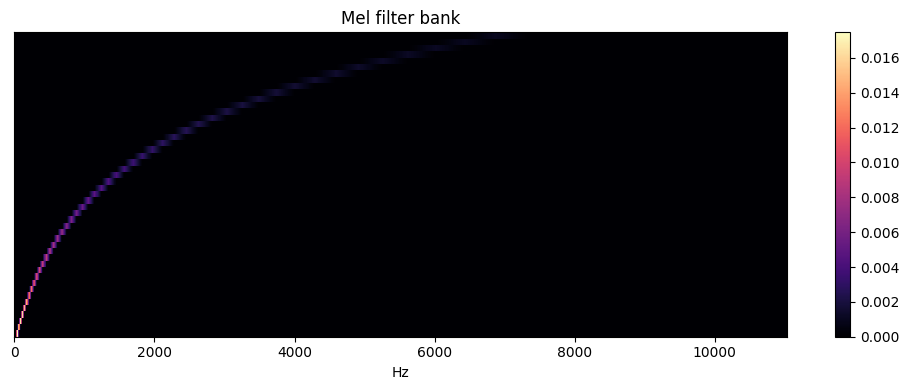

In [ ]:
import librosa
import matplotlib.pyplot as plt

sr = 48000  # Sample rate
n_fft = 3000  # Length of FFT
n_mels = 48  # Number of Mel bands
fmin = 40  # Minimum frequency
fmax = 16000  # Maximum frequency

mel_filter_bank = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels, fmin=fmin, fmax=fmax, htk=True)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_filter_bank, x_axis='linear')
plt.colorbar()
plt.title('Mel filter bank')
plt.tight_layout()
plt.show()

In [ ]:
def readAudioSample(clip):
    # Load audio using librosa
    audio, sample_rate = librosa.load(clip.audio_path, sr=sr)
    return audio

In [19]:
def applyHannWindow(audio):
    # Apply Hann window
    audio_windowed = audio * np.hanning(len(audio))
    return audio_windowed

In [ ]:
def computeSpectrogram(audio_windowed):
    # Compute spectrogram
    S = np.abs(librosa.stft(audio_windowed, n_fft=n_fft, hop_length=n_fft//2))
    return S

In [21]:
def applyMelFilterBank(S):
    # Apply Mel filter bank
    S_mel = np.dot(mel_filter_bank, S)
    return S_mel

In [100]:
def plotSpectrogram(S, title):
    # Display the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), sr=sr, fmin=fmin, fmax=fmax, hop_length=512, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

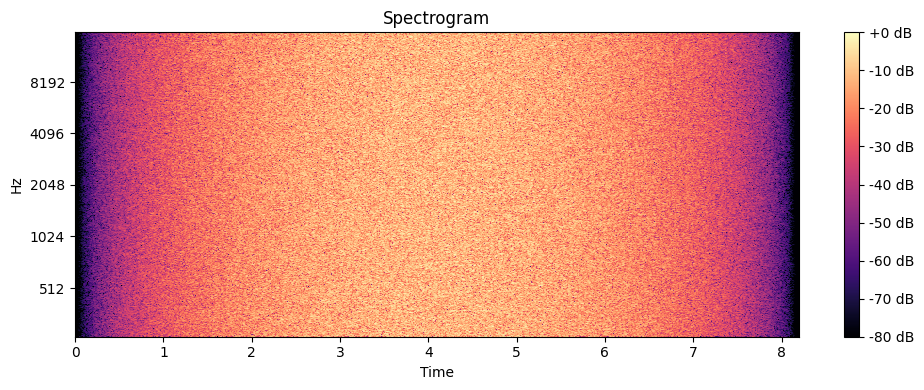

In [102]:
# Generate a random audio sample between 1 and 16 seconds
audio_sample_duration = np.random.randint(1, 17)  # Random duration between 1 and 16 seconds
total_samples = int(sr * audio_sample_duration)

# Generate random audio data
audio_data = np.random.randn(total_samples)

# Apply Hann window
audio_windowed = applyHannWindow(audio_data)

# Compute spectrogram
S = computeSpectrogram(audio_windowed)

# Apply Mel filter bank
S_mel = applyMelFilterBank(S)

# Display the spectrogram
plotSpectrogram(S, 'Spectrogram')

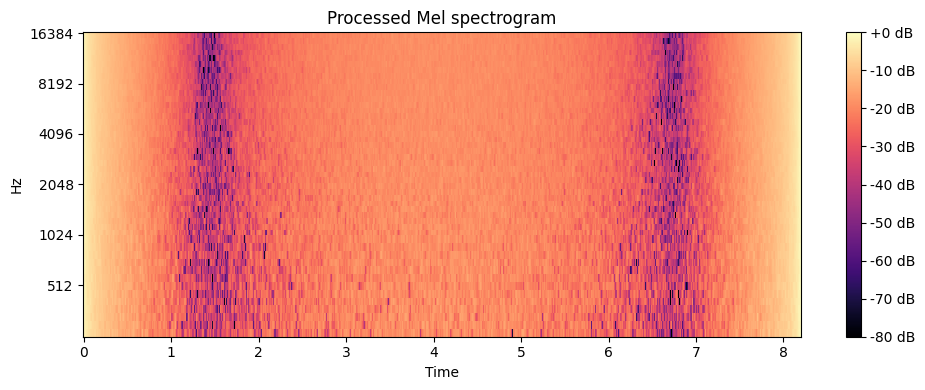

In [103]:
def processMelSpectrogram(S_mel):
    # Apply natural log with a low pass filter
    epsil = 1e-6
    S_mel_log = np.log(S_mel + epsil)
    
    # Normalize the mel spectrogram
    S_mel_norm = S_mel_log - np.max(S_mel_log) + 2
    
    return S_mel_norm

S_mel_processed = processMelSpectrogram(S_mel)

# Display the processed mel spectrogram
plotSpectrogram(S_mel_processed, 'Processed Mel spectrogram')

['drilling']


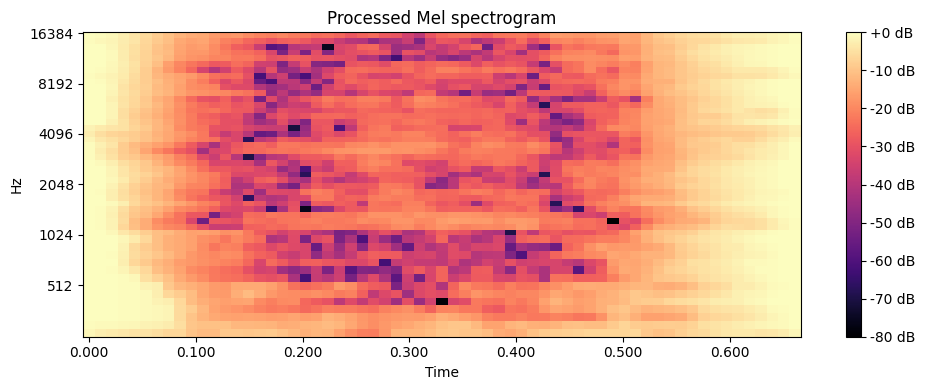

Validation result: True


In [105]:
clip = dataset.choice_clip()

# Load audio using librosa
audio = readAudioSample(clip)

# Apply Hann window
audio_windowed = applyHannWindow(audio)

# Compute spectrogram
S = computeSpectrogram(audio_windowed)

# Apply Mel filter bank
S_mel = applyMelFilterBank(S)

# Process the mel spectrogram
S_mel_processed = processMelSpectrogram(S_mel)

# Display the processed mel spectrogram
print(clip.tags.labels)
plotSpectrogram(S_mel_processed, 'Processed Mel spectrogram')

def validate_mel_spectrogram(S_mel_processed):
    # if S_mel_processed.shape != (48, audio.size):
    #     print(f"Shape: {S_mel_processed.shape}")
    #     raise ValueError("Shape is not valid")
        
    if not (S_mel_processed.min() >= np.log(1e-6) and S_mel_processed.max() <= 2):
        raise ValueError("Frequency range is not valid")
    
    return True

# Validate the processed mel spectrogram
is_valid = validate_mel_spectrogram(S_mel_processed)
print(f"Validation result: {is_valid}")